(1) Fit fMTN after projecting 20-neuron fast-adapt-slow-integrate MA responses onto top 5 PCs.

(2) Examine regressor weights on PCs.

(3) Attempt to interpret what each PC means in order to figure out which features predict slowing.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model, decomposition
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, set_color
from my_torch import skl_fit_ridge
from my_stats import nanpearsonr

from record_0_main import smlt_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

ALPHA = 10

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'
PFX_NRL = f'data/simple/mlv/ma_pc_det/temp_nrl/temp_ma_pc_det_{rand_string(8)}'

MASK_PFX = f'data/simple/masks/mask'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

Load behavioral data from Coen et al 2014

In [3]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [4]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

In [5]:
# function for recording surrogate neural activity and predicting behavior
def record_fit(tau_rs, tau_as, x_ss, x_ps, npc):
    
    # record data
    sys.stdout.write('R')
    
    rs_all = []
    songs_all = []
    
    for itr, df_tr in zip(ISTRAIN, dfs_tr):

        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)

        # simulate population response
        params = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps}
        rs = smlt_ma(i_s, i_p, params, DT)

        rs_all.append(rs.copy())
        
        song = np.zeros(len(i_s))
        song[i_s == 1] = 1
        song[i_p == 1] = 2
        
        songs_all.append(song)
    
    # run PCA on concatenated responses
    pca = decomposition.PCA(n_components=npc).fit(cc(rs_all, axis=0))
    
    # store responses projected onto top pcs in dataframe
    pc_cols = [f'PC_{cpc}' for cpc in range(npc)]
    
    rs_pca_all = []
    
    for itr, df_tr, rs in zip(ISTRAIN, dfs_tr, rs_all):
        df_tr_nrl = df_tr.copy()
        rs_pca = pca.transform(rs)
        df_tr_nrl[pc_cols] = rs_pca
        
        np.save(f'{PFX_NRL}_tr_{itr}.npy', np.array([{'df': df_tr_nrl}]))
        
        rs_pca_all.append(rs_pca)
        
    sys.stdout.write('F')
    # fit neural -> behav regression model
    rslts = skl_fit_ridge(
        pfxs=[PFX_NRL, PFX_BHV],
        cols_x=pc_cols,
        targs=TARGS,
        itr_all=ISTRAIN,
        ntrain=NTRAIN,
        nsplit=NSPLIT,
        alpha=ALPHA,
        mask_pfx=MASK_PFX,
        verbose='dots')
    
    r2_train_mns = {targ: np.mean([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS}
    r2_test_mns = {targ: np.mean([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS}
    
    ws = {targ: np.array([rslt.w[targ] for rslt in rslts]) for targ in TARGS}
    
    
    return r2_train_mns, r2_test_mns, ws, pca, rs_pca_all, songs_all

In [6]:
N = 20
NPC = 5

np.random.seed(0)

tau_rs = np.random.uniform(20, 120, N)
tau_as = np.random.uniform(.1, 2, N)
x_ss = np.random.uniform(0, 1, N)
x_ps = 1 - x_ss

r2_train_mns, r2_test_mns, ws, pca, rs_pca_all, songs_all = record_fit(tau_rs, tau_as, x_ss, x_ps, npc=NPC)

pcs = pca.components_

print('')

RF..............................


In [7]:
print(r2_train_mns)
print(r2_test_mns)

{'MTN_MN_0.03': 0.14913379864195958, 'MTN_MN_1': 0.2563737931445518, 'MTN_MN_60': 0.3392027939185472}
{'MTN_MN_0.03': 0.12281995000505866, 'MTN_MN_1': 0.20666549254372904, 'MTN_MN_60': 0.26350727523841516}


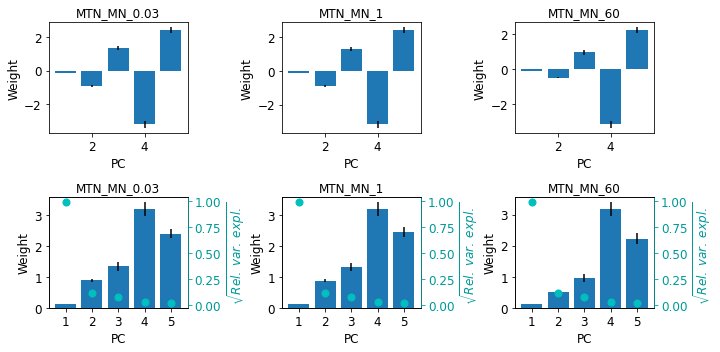

In [8]:
scale = np.sqrt(pca.explained_variance_ratio_)

fig, axs = plt.subplots(2, 3, figsize=(10, 5), tight_layout=True)
for targ, ax_col in zip(TARGS, axs.T):
    ax_col[0].bar(np.arange(NPC)+1, ws[targ].mean(0), yerr=ws[targ].std(0))
    set_plot(ax_col[0], x_label='PC', y_label='Weight', title=targ)
    
    w_signs = np.sign(ws[targ].mean(0))
    ax_col[1].bar(np.arange(NPC)+1, ws[targ].mean(0)*w_signs, yerr=ws[targ].std(0))
    set_plot(ax_col[1], x_ticks=(np.arange(NPC)+1), x_label='PC', y_label='Weight', title=targ)
    
    ax_twin = ax_col[1].twinx()
    ax_twin.scatter(np.arange(NPC)+1, np.sqrt(pca.explained_variance_ratio_), c='c', s=50)
    set_plot(ax_twin, y_label=r'$\sqrt{Rel. \; var. \; expl.}$')
    set_color(ax_twin, (0, .6, .6))

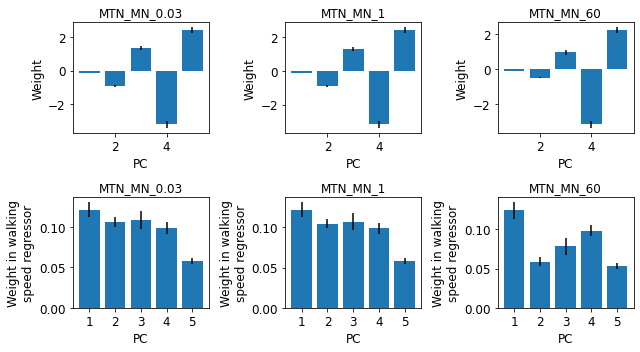

In [9]:
scale = np.sqrt(pca.explained_variance_ratio_)
fig, axs = plt.subplots(2, 3, figsize=(9, 5), tight_layout=True)
for targ, ax_col in zip(TARGS, axs.T):
    ax_col[0].bar(np.arange(NPC)+1, ws[targ].mean(0), yerr=ws[targ].std(0))
    set_plot(ax_col[0], x_label='PC', y_label='Weight', title=targ)
    
    w_signs = np.sign(ws[targ].mean(0))
    ax_col[1].bar(np.arange(NPC)+1, ws[targ].mean(0)*w_signs*scale, yerr=ws[targ].std(0)*scale)
    set_plot(ax_col[1], x_ticks=(np.arange(NPC)+1), x_label='PC', y_label='Weight in walking\nspeed regressor', title=targ)
    
fig.savefig('ms/2_pca_weights_fmtn_regressor.svg')

# Figure out if PCs correspond to obvious song features

PC 1 should correspond to natural song

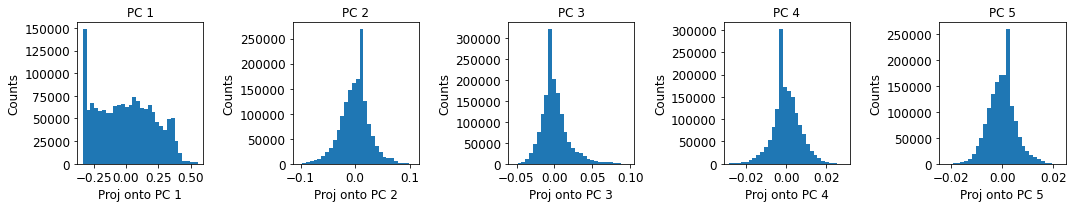

In [10]:
# distributions of projections onto PCs
fig, axs = plt.subplots(1, NPC, figsize=(15, 3), tight_layout=True)
for cpc, ax in enumerate(axs):
    ax.hist(cc(rs_pca_all)[:, cpc], bins=30)
    set_plot(ax, x_label=f'Proj onto PC {cpc+1}', y_label='Counts', title=f'PC {cpc+1}')

In [11]:
def idx_cc_to_song_and_frame(idx, songs):
    # tested and gives correct results
    song_lens = np.array([len(song) for song in songs])
    lens_cum = song_lens.cumsum()
    song_idx = np.sum(lens_cum <= idx)
    
    if song_idx == 0:
        frame = idx
    else:
        frame = idx - lens_cum[song_idx-1]
        
    return song_idx, frame, songs[song_idx][:frame]

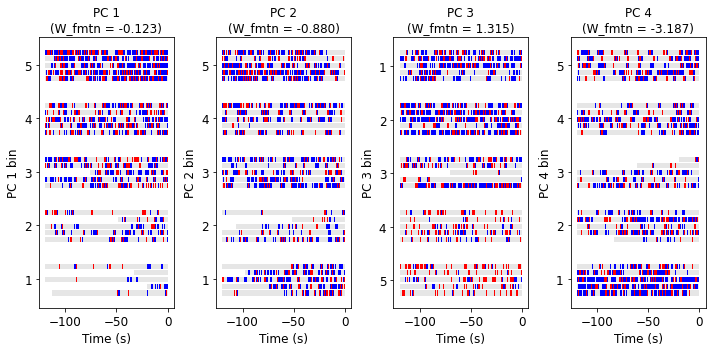

In [12]:
# for each PC select songs corresponding to diff projections onto that PC
np.random.seed(None)
nsong_per_bin = 5
nbin = 5

NPC = 4

fig, axs = plt.subplots(1, NPC, figsize=(10, 5), tight_layout=True)

for cpc, ax in enumerate(axs):
    rs_pc_cc = cc(rs_pca_all)[:, cpc]
    cts, bins = np.histogram(rs_pc_cc, bins=nbin)
    
    # loop over bins and get random songs corresponding to each bin
    y_off = 0
    
    y_ticks = []
    
    for cbin, bin_lb in enumerate(bins[:-1]):
        bin_ub = bins[cbin+1]
        mask = (bin_lb <= rs_pc_cc) & (rs_pc_cc < bin_ub)
        idx_cc = np.nonzero(mask)[0]
        
        # get song examples for this bin
        idx_cc_show = idx_cc[np.random.permutation(len(idx_cc))[:nsong_per_bin]]
        songs_bin = [idx_cc_to_song_and_frame(idx, songs_all)[-1] for idx in idx_cc_show]
        
        songs_bin = [song[-int(np.round(120*FPS)):] if len(song) > int(np.round(120*FPS)) else song for song in songs_bin]
        
        for song in songs_bin:
            t = np.arange(len(song))*DT
            
            plot_b(ax, t, song, extent=[-t.max(), 0, y_off, y_off+.75], c=((.9, .9, .9), 'b', 'r'))
                   
            y_off += 1
            
        y_ticks.append(y_off - nsong_per_bin/2)
        
        y_off += 3
        
    y_tick_labels = [f'{binc:.3f}' for binc in .5*(bins[:-1] + bins[1:])]
    
    weight = ws['MTN_MN_1'].mean(axis=0)[cpc]
        
    if weight > 0:
        ax.invert_yaxis()
        
    set_plot(
        ax, y_ticks=y_ticks, y_tick_labels=(1+np.arange(nbin)),
        x_label='Time (s)', y_label=f'PC {cpc+1} bin', title=f'PC {cpc+1}\n(W_fmtn = {weight:.3f})')
    
fig.savefig('ms/2_songs_vs_pc_projs_fast_ad_slow_int.svg')

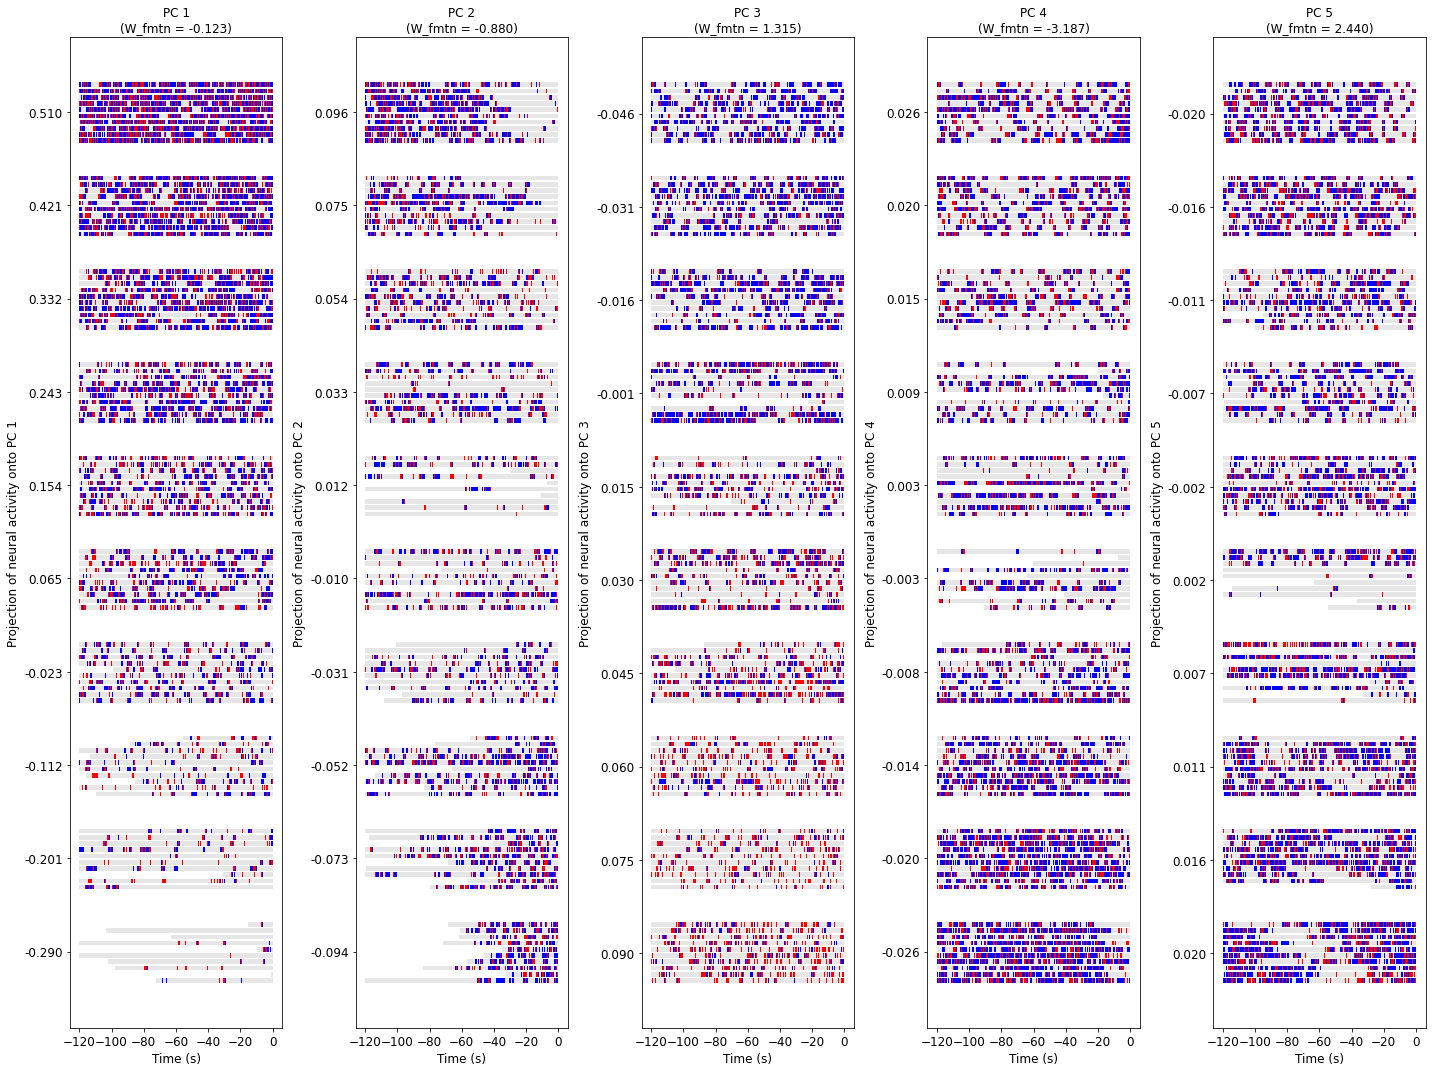

In [13]:
# for each PC select songs corresponding to diff projections onto that PC
nsong_per_bin = 10

NPC = 5

fig, axs = plt.subplots(1, NPC, figsize=(20, 15), tight_layout=True)

for cpc, ax in enumerate(axs):
    rs_pc_cc = cc(rs_pca_all)[:, cpc]
    cts, bins = np.histogram(rs_pc_cc, bins=10)
    
    # loop over bins and get random songs corresponding to each bin
    y_off = 0
    
    y_ticks = []
    
    for cbin, bin_lb in enumerate(bins[:-1]):
        bin_ub = bins[cbin+1]
        mask = (bin_lb <= rs_pc_cc) & (rs_pc_cc < bin_ub)
        idx_cc = np.nonzero(mask)[0]
        
        # get song examples for this bin
        idx_cc_show = idx_cc[np.random.permutation(len(idx_cc))[:nsong_per_bin]]
        songs_bin = [idx_cc_to_song_and_frame(idx, songs_all)[-1] for idx in idx_cc_show]
        
        songs_bin = [song[-int(np.round(120*FPS)):] if len(song) > int(np.round(120*FPS)) else song for song in songs_bin]
        
        for song in songs_bin:
            t = np.arange(len(song))*DT
            
            plot_b(ax, t, song, extent=[-t.max(), 0, y_off, y_off+.75], c=((.9, .9, .9), 'b', 'r'))
                   
            y_off += 1
            
        y_ticks.append(y_off - nsong_per_bin/2)
        
        y_off += 5
        
    y_tick_labels = [f'{binc:.3f}' for binc in .5*(bins[:-1] + bins[1:])]
    
    weight = ws['MTN_MN_1'].mean(axis=0)[cpc]
        
    if weight > 0:
        ax.invert_yaxis()
        
    set_plot(
        ax, y_ticks=y_ticks, y_tick_labels=y_tick_labels,
        x_label='Time (s)', y_label=f'Projection of neural activity onto PC {cpc+1}', title=f'PC {cpc+1}\n(W_fmtn = {weight:.3f})')
    
fig.savefig('supp/17_songs_vs_pc_projs_fast_ad_slow_int.svg')

# Analyze PC 4